## Importing necessary libraries for making random waldo picture

In [1]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
import glob

In [2]:
IMAGE_WIDTH = 800
IMAGE_HEIGHT = 600

In [3]:
def resize_background(bg_path, target_width, target_height):
    with Image.open(bg_path) as bg:
        bg_width, bg_height = bg.size
#         Enlarge
        if bg_width < target_width or bg_height < target_height:
            resized_bg = bg.resize((target_width, target_height), Image.LANCZOS)
#             Reduce
        elif bg_width > target_width or bg_height > target_height:
            resized_bg = bg.resize((target_width, target_height), Image.ANTIALIAS)
        else:
            resized_bg = bg.copy()  # Copy to ensure we don't return a closed image
        return resized_bg

In [4]:
def place_waldo_on_bg(waldo_path, bg_image):
    # Ensure the background is in RGBA
    bg_image = bg_image.convert("RGBA")

    # Open the Waldo image (in PNG format)
    with Image.open(waldo_path) as waldo:
        waldo = waldo.convert("RGBA")  # Ensure Waldo is in RGBA mode 
        waldo_width, waldo_height = waldo.size
        bg_width, bg_height = bg_image.size
        
        # Scale Waldo 
        if waldo_width > bg_width or waldo_height > bg_height:
            factor = min((bg_width * .2) / waldo_width, (bg_height * .2) / waldo_height)
            waldo = waldo.resize((int(waldo_width * factor), int(waldo_height * factor)), Image.LANCZOS)
            waldo_width, waldo_height = waldo.size
        
        # Random location for Waldo
        max_width_position = bg_width - waldo_width
        max_height_position = bg_height - waldo_height
        position_width = random.randint(0, max_width_position)
        position_height = random.randint(0, max_height_position)
        
        bg_image.paste(waldo, (position_width, position_height), waldo)

        # Convert the result back to RGB to save in JPEG format
        bg_image = bg_image.convert("RGB")
        
        return bg_image

In [5]:
def send_img_to_directory(directory_path, image, file_name):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # Check if the image has an alpha channel (RGBA)
    if image.mode == 'RGBA':
        # Create a white RGB background
        background = Image.new('RGB', image.size, (255, 255, 255))
        # Paste using alpha channel as mask
        background.paste(image, (0, 0), image)
        image = background

    file_path = os.path.join(directory_path, file_name)
    image.save(file_path, 'JPEG')

In [6]:
waldo_path = 'data/images/waldo.png'
waldo = Image.open(waldo_path)
background_paths = glob.glob('data/images/*.jpg') + glob.glob('data/images/*.jpeg')

for i, bg_path in enumerate(background_paths):
    resized_bg = resize_background(bg_path=bg_path, target_width=IMAGE_WIDTH, target_height=IMAGE_HEIGHT)
    background_with_waldo = place_waldo_on_bg(waldo_path=waldo_path, bg_image=resized_bg)
    file_name = f'bg{i+1}_with_waldo.jpg'
    send_img_to_directory(directory_path='data/created_images', image=background_with_waldo, file_name=file_name)

/var/folders/jk/524t5p750nl3f8pm6p6q2bv40000gn/T/ipykernel_3902/1179995627.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_bg = bg.resize((target_width, target_height), Image.ANTIALIAS)


## Label the waldo for each generated picture using labelme

In [8]:
!labelme

2024-01-20 15:52:15,353 [INFO   ] __init__:get_config:67- Loading config file from: /Users/lukiee/.labelmerc


## Make the image file into array

In [9]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

In [12]:
images = tf.data.Dataset.list_files('data/created_images/*.jpg', shuffle=False)

In [14]:
def load_image(file_path):
    byte_img = tf.io.read_file(file_path) # byte coded image
    img = tf.io.decode_jpeg(byte_img)  # decote it
    return img

In [15]:
images = images.map(load_image) # apply load image function for each value in the dataset. 

In [16]:
images.as_numpy_iterator().next()

array([[[108,  62,  65],
        [ 85,  40,  43],
        [ 63,  18,  23],
        ...,
        [125, 114, 118],
        [136, 125, 129],
        [144, 134, 135]],

       [[ 92,  46,  49],
        [ 74,  29,  32],
        [ 59,  14,  19],
        ...,
        [154, 143, 147],
        [162, 152, 153],
        [168, 158, 159]],

       [[ 73,  27,  30],
        [ 61,  16,  19],
        [ 54,   9,  14],
        ...,
        [166, 155, 159],
        [172, 162, 163],
        [176, 166, 167]],

       ...,

       [[240, 157, 149],
        [241, 163, 153],
        [242, 168, 159],
        ...,
        [ 91,  79, 103],
        [131, 119, 143],
        [116, 104, 128]],

       [[244, 155, 147],
        [246, 162, 152],
        [248, 168, 159],
        ...,
        [ 71,  62,  83],
        [113, 103, 127],
        [138, 128, 152]],

       [[247, 157, 148],
        [253, 165, 155],
        [255, 173, 162],
        ...,
        [ 94,  85, 106],
        [115, 105, 129],
        [166, 156, 180]]

In [17]:
# batch returns the number of the parameter. In this case, it returns 4 images. 
image_generator = images.batch(4).as_numpy_iterator()

In [23]:
plot_images = image_generator.next()

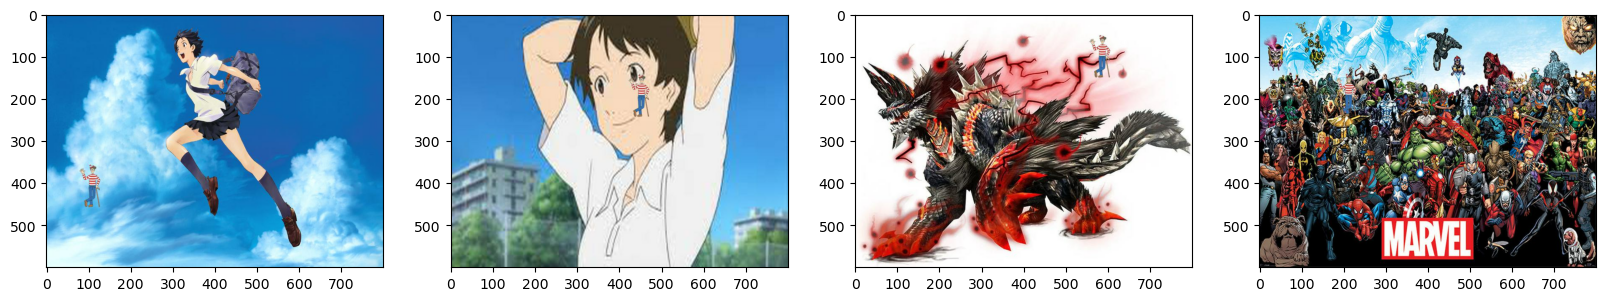

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

## Splitting image and json file into train, test and validation

In [34]:
from sklearn.model_selection import train_test_split
import shutil

images_dir = 'data/created_images'
json_dir = 'data/processed_img_info'

image_paths = []
json_paths = []

# Load Images and corresponding Json file.
for image_file in os.listdir(images_dir):
    if image_file.endswith('.jpg'):
        image_path = os.path.join(images_dir, image_file)
        json_file = image_file.replace('.jpg', '.json')
        json_path = os.path.join(json_dir, json_file)
        
        if os.path.exists(json_path):
            image_paths.append(image_path)
            json_paths.append(json_path)
            
# Split data
train_img_paths, test_val_img_paths, train_json_paths, test_val_json_paths = train_test_split(image_paths, json_paths, test_size=0.3, random_state=42)
test_img_paths, val_img_paths, test_json_path, val_json_path = train_test_split(test_val_img_paths, test_val_json_paths, test_size=0.5, random_state=42)

# Copy files into respective directories
def copy_files(image_paths, json_paths, target_img_dir, target_json_dir):
    os.makedirs(target_img_dir, exist_ok=True)
    os.makedirs(target_json_dir, exist_ok=True)
    
    for img_path, json_path in zip(image_paths, json_paths):
        shutil.copy(img_path, target_img_dir)
        shutil.copy(json_path, target_json_dir)

In [36]:
copy_files(train_img_paths, train_json_paths, 'data/train/images', 'data/train/labels')
copy_files(test_img_paths, test_json_path, 'data/test/images', 'data/test/labels')
copy_files(val_img_paths, val_json_path, 'data/validation/images', 'data/validation/labels')

## Image augmentation Test

In [38]:
import albumentations as alb

In [39]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.2)],
                        bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [42]:
# Just testing functionality of albumentations
img = cv2.imread(os.path.join('data', 'train', 'images', 'bg15_with_waldo.jpg'))

In [43]:
with open(os.path.join('data', 'train', 'labels', 'bg15_with_waldo.json'), 'r') as f:
    label = json.load(f)

In [50]:
label['shapes'][0]['points']

[[62.244897959183675, 358.16326530612247],
 [113.26530612244899, 459.18367346938777]]

In [55]:
# Extract coordinates from label['shapes'][0]['points']
coords = [0, 0, 0, 0] # [top x, top y, bottom x, bottom y]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [54]:
coords

[62.244897959183675,
 358.16326530612247,
 113.26530612244899,
 459.18367346938777]

In [56]:
coords = list(np.divide(coords, [IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_HEIGHT]))
coords

[0.0778061224489796,
 0.5969387755102041,
 0.14158163265306123,
 0.7653061224489797]

In [57]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['waldo'])
augmented

{'image': array([[[255, 255, 221],
         [255, 255, 220],
         [255, 255, 218],
         ...,
         [220, 178, 124],
         [210, 168, 110],
         [213, 166, 109]],
 
        [[255, 255, 222],
         [255, 255, 222],
         [255, 255, 221],
         ...,
         [219, 181, 129],
         [211, 172, 117],
         [213, 170, 116]],
 
        [[255, 255, 224],
         [255, 255, 224],
         [255, 255, 224],
         ...,
         [221, 186, 136],
         [218, 180, 128],
         [220, 180, 127]],
 
        ...,
 
        [[219, 221, 216],
         [223, 226, 220],
         [220, 223, 216],
         ...,
         [ 77,  74,  67],
         [ 77,  74,  67],
         [ 77,  74,  67]],
 
        [[196, 198, 194],
         [199, 202, 197],
         [201, 205, 198],
         ...,
         [ 74,  71,  64],
         [ 74,  71,  64],
         [ 75,  72,  65]],
 
        [[174, 177, 172],
         [179, 181, 176],
         [187, 191, 184],
         ...,
         [ 72,  69,

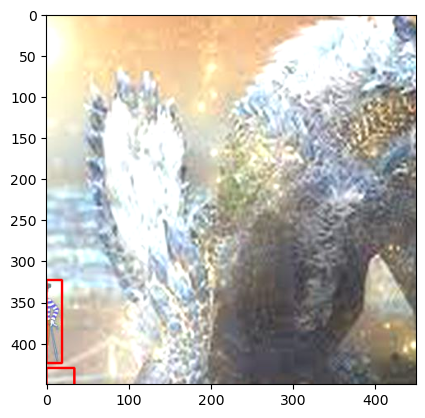

In [60]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)), # multiply the top x and top y by 450
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)), # multiply the bottom x and bottom y by 450
              (255, 0, 0), 2) # color of the rectangle, width of rectangle
plt.imshow(augmented['image'])

## Do Augmentation for every images

In [64]:
for partition in ['train','test','validation']: 
#   Load up the image and make corrdinates 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_WIDTH, IMAGE_HEIGHT]))

#       Make augmented version of iamges for 60 times for each images. 
        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['waldo'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
